# Model Free RL : Taxi-v3 
## Armin Attarzadeh

### Imports

In [1]:
import gym
import random
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import clear_output

### Random Agent Run

In [133]:
def run_agent(env_name, agent_type='random', Q=None):
    env = gym.make(env_name, new_step_api=True)
    obs = env.reset()
    done = False
    total_reward = 0
    total_steps = 0

    while not done and total_steps < 20:
        if agent_type == 'random':
            action = env.action_space.sample()
        elif agent_type == 'trained':
            action = np.argmax(Q[obs])
        else:
            raise ValueError("Invalid agent_type. Use 'random' or 'trained'.")

        obs, reward, done, _, info = env.step(action)
        total_reward += reward
        total_steps += 1
        env.render()

        # When we reach the goal, reset the environment
        if done:
            obs = env.reset()

    env.close()
    print("Total reward: ", total_reward)
    print("Total steps: ", total_steps)

Q_table=on_monte_carlo_q_tables
run_agent('Taxi-v3', agent_type='random')
#run_agent('Taxi-v3', agent_type='trained', Q=Q_table)

Total reward:  -65
Total steps:  20


# PART A: MC

### A1) Implementing On-Policy Monte Carlo Control (e-Greedy soft Policy)

In [144]:

class OnPolicyMonteCarloAgent:
    def __init__(self, env_name, gamma=1, epsilon=0.5):
        self.env = gym.make(env_name)
        self.gamma = gamma # discount factor
        self.epsilon = epsilon # eexploration rate
        self.Q = np.zeros([self.env.observation_space.n, self.env.action_space.n]) # Q table
        self.N = np.zeros([self.env.observation_space.n, self.env.action_space.n]) # N table
        self.policy = self.create_epsilon_soft_policy() # epsilon-soft policy
        self.returns = {(s,a):[] for s in range(self.env.observation_space.n) for a in range(self.env.action_space.n)} # dictionary of lists of returns for each state-action pair

    def create_epsilon_soft_policy(self):
        #returns an epsilon-soft policy
        def policy(state):
            action_probs = np.ones(self.env.action_space.n) * self.epsilon / self.env.action_space.n
            best_action = np.argmax(self.Q[state])
            action_probs[best_action] += (1.0 - self.epsilon)
            return action_probs
        return policy
    
    def choose_action(self, state):
        #returns an action given a state based on the epsilon-soft policy
        action_probs = self.policy(state)
        action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
        return action
    
    #update Q table based on the episode
    def learn(self, episode):
        states, actions, rewards = zip(*episode)
        discounts = np.array([self.gamma**i for i in range(len(rewards)+1)])
        for i, state in enumerate(states):
            G = sum(rewards[i:]*discounts[:-(1+i)])
            self.N[state, actions[i]] += 1
            alpha = 1.0 / self.N[state, actions[i]]
            self.Q[state, actions[i]] += alpha * (G - self.Q[state, actions[i]])

    def run(self, num_episodes=200):
        rewards = []
        best_episode_reward = -1000
        best_episode = 0
        for episode in range(num_episodes):
            state = self.env.reset()
            done = False
            episode_rewards = []
            episode_states = []
            episode_actions = []
            covered_states = set()
            while not done:
                action = self.choose_action(state) #choose an action
                next_state, reward, done, info = self.env.step(action) #take action
                episode_rewards.append(reward) #store reward
                episode_states.append(state) #store state
                episode_actions.append(action) #store action
                covered_states.add(state) #add state to covered states
                state = next_state #update state
            episode_rewards = np.array(episode_rewards)
            rewards.append(sum(episode_rewards)) 
            if sum(episode_rewards) > best_episode_reward:
                best_episode_reward = sum(episode_rewards)
                best_episode = episode
            self.learn(zip(episode_states, episode_actions, episode_rewards)) #update Q table
        return rewards, best_episode_reward, best_episode,  self.Q
    
#Function to plot the rewards(over N runs) vs episodes during training
def plot_rewards(rewards):
    plt.plot(rewards)
    plt.xlabel("Episode")
    plt.ylabel("Total reward")
    plt.show()


C:\ProgramData\Anaconda3\lib\site-packages\gym\core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
C:\ProgramData\Anaconda3\lib\site-packages\gym\wrappers\step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Average reward over the runs: 


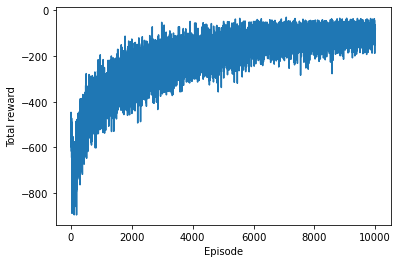

----------------------------------
Mean of best episode rewards:  14.9
Mean of best episodes:  5114.4


In [145]:
runs = 10
num_episodes = 10000
on_monte_carlo_rewards = np.zeros((runs, num_episodes))
on_monte_carlo_best_episode_rewards = np.zeros(runs)
on_monte_carlo_best_episodes = np.zeros(runs)
on_monte_carlo_q_tables = np.zeros((runs, 500, 6))


for run in range(runs):
    agent = OnPolicyMonteCarloAgent('Taxi-v3') 
    
    rewards, best_reward, best_episode, q_table = agent.run(num_episodes)

    on_monte_carlo_rewards[run, :] = rewards
    on_monte_carlo_best_episode_rewards[run] = best_reward
    on_monte_carlo_best_episodes[run] = best_episode
    on_monte_carlo_q_tables[run, :, :] = q_table

#We plot the average reward over the N runs
print("Average reward over the runs: ")
plot_rewards(np.mean(on_monte_carlo_rewards, axis=0))

print("----------------------------------")

#We print the best reward and the episode in which it was obtained
print("Mean of best episode rewards: ", np.mean(on_monte_carlo_best_episode_rewards))
print("Mean of best episodes: ", np.mean(on_monte_carlo_best_episodes))




###  A2- OFF-Policy Monte Carlo Using Importance Sampling
#### (Flag) Average methods : 'ordinary' or 'weighted'

In [88]:
class OffPolicyMonteCarloAgent:
    def __init__(self, env_name, importance_sampling='weighted'و gamma=1, epsilon=0.1):
        self.env = gym.make(env_name)
        self.gamma = gamma  # discount factor
        self.epsilon = epsilon  # exploration rate
        self.Q = np.zeros([self.env.observation_space.n, self.env.action_space.n])  # Q table
        self.C = np.zeros([self.env.observation_space.n, self.env.action_space.n])  # C table
        self.target_policy = self.create_epsilon_soft_policy()  # target policy (can be any arbitrary policy)
        self.behavior_policy = self.create_epsilon_soft_policy()  # behavior policy
        self.returns = {(s, a): [] for s in range(self.env.observation_space.n) for a in range(self.env.action_space.n)}  # dictionary of lists of returns for each state-action pair
        self.importance_sampling = importance_sampling  # Flag for selecting 'ordinary' or 'weighted'

    def create_epsilon_soft_policy(self):
        def policy(state):
            action_probs = np.ones(self.env.action_space.n) * self.epsilon / self.env.action_space.n
            best_action = np.argmax(self.Q[state])
            action_probs[best_action] += (1.0 - self.epsilon)
            return action_probs
        return policy

    def choose_action(self, state, policy):
        # returns an action given a state based on a given policy
        action_probs = policy(state)
        action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
        return action

    # update Q table based on the episode
    def learn(self, episode):
        states, actions, rewards = zip(*episode)
        discounts = np.array([self.gamma**i for i in range(len(rewards)+1)])
        W = 1.0
        G = 0
        for i in reversed(range(len(states))):
            state = states[i]
            action = actions[i]
            reward = rewards[i]
            G = self.gamma * G + reward
            self.C[state, action] += W

            if self.importance_sampling == 'weighted':
                self.Q[state, action] += (W / self.C[state, action]) * (G - self.Q[state, action])
                W = W * 1.0 / self.behavior_policy(state)[action]
            elif self.importance_sampling == 'ordinary':
                self.Q[state, action] += (1.0 / self.C[state, action]) * (G - self.Q[state, action])

            self.returns[(state, action)].append(G)

            if self.target_policy(state)[action] != self.behavior_policy(state)[action]:
                break

    def run(self, num_episodes=200):
        rewards = []
        best_episode_reward = -1000
        best_episode = 0
        for episode in range(num_episodes):
            state = self.env.reset()
            done = False
            episode_rewards = []
            episode_states = []
            episode_actions = []
            covered_states = set()
            while not done:
                action = self.choose_action(state, self.behavior_policy)
                next_state, reward, done, info = self.env.step(action)
                episode_rewards.append(reward)
                episode_states.append(state)
                episode_actions.append(action)
                covered_states.add(state)  # we add the state to the set of covered states
                state = next_state
            episode_rewards = np.array(episode_rewards)
            rewards.append(sum(episode_rewards))
            if sum(episode_rewards) > best_episode_reward:
                best_episode_reward = sum(episode_rewards)
                best_episode = episode
            self.learn(zip(episode_states, episode_actions, episode_rewards))
        return rewards, best_episode_reward, best_episode, self.Q 


#### Off-Policy MC: ordinary

C:\ProgramData\Anaconda3\lib\site-packages\gym\core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
C:\ProgramData\Anaconda3\lib\site-packages\gym\wrappers\step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
C:\ProgramData\Anaconda3\lib\site-packages\gym\utils\passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Average reward over the runs


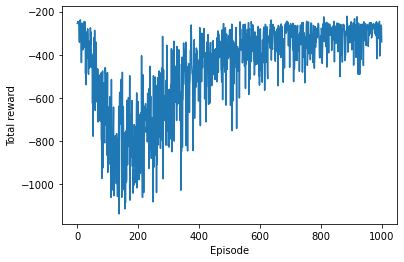

----------------------------------
Mean of best episode rewards:  -47.7
Mean of best episodes:  408.2
----------------------------------


In [89]:
runs = 10
num_episodes = 1000

off_policy_monte_carlo_rewards1 = np.zeros((runs, num_episodes))
off_policy_monte_carlo_best_episode_rewards1 = np.zeros(runs)
off_policy_monte_carlo_best_episodes1 = np.zeros(runs)
off_policy_monte_carlo_q_tables1 = np.zeros((runs, 500, 6))

for run in range(runs):
    agent = OffPolicyMonteCarloAgent('Taxi-v3','ordinary')
    
    
    rewards, best_reward, best_episode, q_table = agent.run(num_episodes)

    off_policy_monte_carlo_rewards1[run, :] = rewards
    off_policy_monte_carlo_best_episode_rewards1[run] = best_reward
    off_policy_monte_carlo_best_episodes1[run] = best_episode
    off_policy_monte_carlo_q_tables1[run, :, :] = q_table

#We plot the average reward over the N runs
print("Average reward over the runs")
plot_rewards(np.mean(off_policy_monte_carlo_rewards1, axis=0))

print("----------------------------------")

#We print the best reward and the episode in which it was obtained
print("Mean of best episode rewards: ", np.mean(off_policy_monte_carlo_best_episode_rewards1))
print("Mean of best episodes: ", np.mean(off_policy_monte_carlo_best_episodes1))

print("----------------------------------")

#### Off-Policy MC: weighted

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\ProgramData\Anaconda3\lib\site-packages\gym\core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
C:\ProgramData\Anaconda3\lib\site-packages\gym\wrappers\step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
C:\ProgramData\Anaconda3\lib\site-

Average reward over the runs


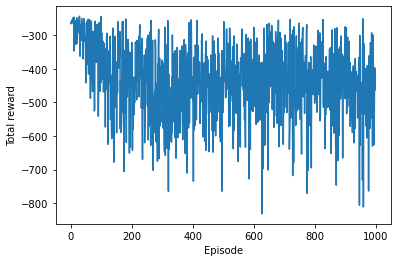

----------------------------------
Mean of best episode rewards:  -22.1
Mean of best episodes:  670.9
----------------------------------


In [90]:
runs = 10
num_episodes = 1000

off_policy_monte_carlo_rewards2 = np.zeros((runs, num_episodes))
off_policy_monte_carlo_best_episode_rewards2 = np.zeros(runs)
off_policy_monte_carlo_best_episodes2 = np.zeros(runs)
off_policy_monte_carlo_q_tables2 = np.zeros((runs, 500, 6))

for run in range(runs):
    agent = OffPolicyMonteCarloAgent('Taxi-v3','weighted')
    
    
    rewards, best_reward, best_episode, q_table = agent.run(num_episodes)

    off_policy_monte_carlo_rewards2[run, :] = rewards
    off_policy_monte_carlo_best_episode_rewards2[run] = best_reward
    off_policy_monte_carlo_best_episodes2[run] = best_episode
    off_policy_monte_carlo_q_tables2[run, :, :] = q_table

#We plot the average reward over the N runs
print("Average reward over the runs")
plot_rewards(np.mean(off_policy_monte_carlo_rewards2, axis=0))

print("----------------------------------")

#We print the best reward and the episode in which it was obtained
print("Mean of best episode rewards: ", np.mean(off_policy_monte_carlo_best_episode_rewards2))
print("Mean of best episodes: ", np.mean(off_policy_monte_carlo_best_episodes2))

print("----------------------------------")

# PART B: TD

### B1) Implementing Q-Learning


In [92]:
class QLearningAgent:
    def __init__(self, env_name, alpha=0.5, gamma=1, epsilon=0.1):
        self.env = gym.make(env_name)
        self.Q = np.zeros((self.env.observation_space.n, self.env.action_space.n))
        self.alpha = alpha #learning rate
        self.gamma = gamma #discount factor
        self.epsilon = epsilon #exploration rate

    def choose_action(self, state): 
        #returns an action given a state based on the epsilon-greedy policy
        if random.uniform(0, 1) < self.epsilon:
            action = np.random.choice(self.env.action_space.n) 
        else:
            action = np.argmax(self.Q[state, :])
        return action
    
    def learn(self, state, action, reward, next_state):
        #update Q table
        self.Q[state, action] = self.Q[state, action] + self.alpha * (reward + self.gamma * np.max(self.Q[next_state, :]) - self.Q[state, action])
        
    def run(self, num_episodes=1000):
        rewards = []
        best_episode_reward = -1000
        best_episode = 0
        for episode in range(num_episodes):
            state = self.env.reset()
            done = False
            total_reward = 0
            while not done:
                action = self.choose_action(state) #choose an action
                next_state, reward, done, info = self.env.step(action) #take action
                self.learn(state, action, reward, next_state) #update Q table
                state = next_state #update state
                total_reward += reward #update total reward
            rewards.append(total_reward)
            if total_reward > best_episode_reward:
                best_episode_reward = total_reward
                best_episode = episode
        return rewards, best_episode_reward, best_episode , self.Q

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\ProgramData\Anaconda3\lib\site-packages\gym\core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
C:\ProgramData\Anaconda3\lib\site-packages\gym\wrappers\step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
C:\ProgramData\Anaconda3\lib\site-

Average reward over the runs: 


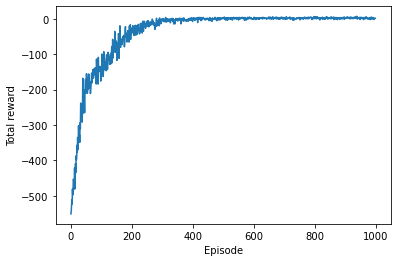

----------------------------------
Mean of best episode rewards:  14.95
Mean of best episodes:  348.05
----------------------------------


In [99]:
runs = 20
num_episodes = 1000
q_learn_rewards = np.zeros((runs, num_episodes))
q_learn_best_episode_rewards = np.zeros(runs)
q_learn_best_episodes = np.zeros(runs)
q_learn_Q_table=np.zeros((runs, 500, 6))

for run in range(runs):
    agent = QLearningAgent('Taxi-v3') 
    q_learn_rewards[run, :], q_learn_best_episode_rewards[run], q_learn_best_episodes[run] , q_learn_Q_table[run, :, :] = agent.run(num_episodes)
    
#We plot the average reward over the N runs
print("Average reward over the runs: ")
plot_rewards(np.mean(q_learn_rewards, axis=0)) 

print("----------------------------------")

#We print the best reward and the episode in which it was obtained

print("Mean of best episode rewards: ", np.mean(q_learn_best_episode_rewards))
print("Mean of best episodes: ", np.mean(q_learn_best_episodes))

print("----------------------------------")

### B2) Implementing Sarsa

In [101]:
class SarsaAgent:
    def __init__(self, env_name, alpha=0.5, gamma=1, epsilon=0.1):
        self.env = gym.make(env_name)
        self.Q = np.zeros((self.env.observation_space.n, self.env.action_space.n))
        self.alpha = alpha #learning rate
        self.gamma = gamma #discount factor
        self.epsilon = epsilon #exploration rate

    def choose_action(self, state): 
        #returns an action given a state based on the epsilon-greedy policy
        if random.uniform(0, 1) < self.epsilon:
            action = self.env.action_space.sample()
        else:
            action = np.argmax(self.Q[state, :])
        return action
    
    def learn(self, state, action, reward, next_state, next_action):
        #update Q table
        self.Q[state, action] = self.Q[state, action] + self.alpha * (reward + self.gamma * self.Q[next_state, next_action] - self.Q[state, action])
        
    def run(self, num_episodes=1000):
        rewards = []
        best_episode_reward = -1000
        best_episode = 0
        for episode in range(num_episodes):
            state = self.env.reset()
            done = False
            total_reward = 0
            action = self.choose_action(state)
            while not done:
                next_state, reward, done, info = self.env.step(action) #take action
                next_action = self.choose_action(next_state) #choose next action
                self.learn(state, action, reward, next_state, next_action) #update Q table
                state = next_state #update state
                action = next_action #update action
                total_reward += reward #update total reward
            rewards.append(total_reward)
            if total_reward > best_episode_reward:
                best_episode_reward = total_reward
                best_episode = episode
        return rewards, best_episode_reward, best_episode , self.Q
    

C:\ProgramData\Anaconda3\lib\site-packages\gym\core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
C:\ProgramData\Anaconda3\lib\site-packages\gym\wrappers\step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
C:\ProgramData\Anaconda3\lib\site-packages\gym\utils\passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Average reward over the runs: 


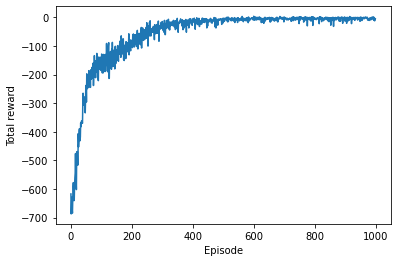

----------------------------------
Mean of best episode rewards:  14.95
Mean of best episodes:  371.2
----------------------------------


In [102]:
runs = 20
num_episodes = 1000
sarsa_rewards = np.zeros((runs, num_episodes))
sarsa_best_episode_rewards = np.zeros(runs)
sarsa_best_episodes = np.zeros(runs)
sarsa_learn_Q_table=np.zeros((runs, 500, 6))

for run in range(runs):
    agent = SarsaAgent('Taxi-v3') 
    sarsa_rewards[run, :], sarsa_best_episode_rewards[run], sarsa_best_episodes[run],sarsa_learn_Q_table[run, :, :] = agent.run(num_episodes)

#We plot the average reward over the N runs
print("Average reward over the runs: ")
plot_rewards(np.mean(sarsa_rewards, axis=0))

print("----------------------------------")

#We print the best reward and the episode in which it was obtained

print("Mean of best episode rewards: ", np.mean(sarsa_best_episode_rewards))
print("Mean of best episodes: ", np.mean(sarsa_best_episodes))

print("----------------------------------")

## Part C : RUN trained agents

### MC ON-Policy 

In [153]:
runs = 10
for run in range(runs):
    run_agent('Taxi-v3', agent_type='trained', Q=on_monte_carlo_q_tables[run,: ,:])

Total reward:  6
Total steps:  15
Total reward:  3
Total steps:  18
Total reward:  12
Total steps:  9
Total reward:  -20
Total steps:  20
Total reward:  5
Total steps:  16
Total reward:  12
Total steps:  9
Total reward:  6
Total steps:  15
Total reward:  9
Total steps:  12
Total reward:  -20
Total steps:  20
Total reward:  10
Total steps:  11


### Q Learning Policy Run

In [154]:
runs = 10
for run in range(runs):
    run_agent('Taxi-v3', agent_type='trained', Q=q_learn_Q_table[run,: ,:])

Total reward:  8
Total steps:  13
Total reward:  10
Total steps:  11
Total reward:  6
Total steps:  15
Total reward:  6
Total steps:  15
Total reward:  8
Total steps:  13
Total reward:  5
Total steps:  16
Total reward:  10
Total steps:  11
Total reward:  6
Total steps:  15
Total reward:  8
Total steps:  13
Total reward:  11
Total steps:  10


### SARSA Policy Run

In [155]:
runs = 10
for run in range(runs):
    run_agent('Taxi-v3', agent_type='trained', Q=sarsa_learn_Q_table[run,: ,:])

Total reward:  7
Total steps:  14
Total reward:  6
Total steps:  15
Total reward:  -20
Total steps:  20
Total reward:  -20
Total steps:  20
Total reward:  10
Total steps:  11
Total reward:  6
Total steps:  15
Total reward:  9
Total steps:  12
Total reward:  10
Total steps:  11
Total reward:  7
Total steps:  14
Total reward:  -20
Total steps:  20


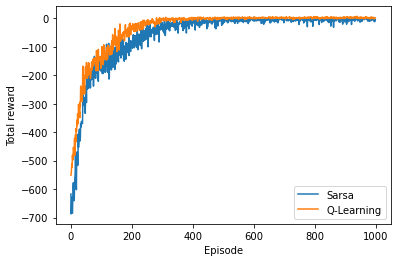

In [148]:
#plot all curves
#plt.plot(np.mean(off_policy_monte_carlo_rewards2, axis=0), label="Off-Policy Monte Carlo")
#plt.plot(np.mean(on_monte_carlo_rewards, axis=0), label="On-Policy Monte Carlo")
plt.plot(np.mean(sarsa_rewards, axis=0), label="Sarsa")
plt.plot(np.mean(q_learn_rewards, axis=0), label="Q-Learning")
plt.xlabel("Episode")
plt.ylabel("Total reward")
plt.legend()
plt.show()